# 國內成份股 ETF

In [1]:
import crawler
import importlib
importlib.reload(crawler)
from crawler import Crawler                
import time
from io import StringIO
import pandas as pd
eft_url = "https://www.twse.com.tw/zh/products/securities/etf/products/domestic.html"
crawler_etf = Crawler(remote=True, diff_container=True)
driver = crawler_etf.configure_driver()
driver.get(eft_url)
time.sleep(2)
html_buffer = StringIO(driver.page_source)
df_eft_domestic = pd.read_html(html_buffer)[0]
driver.quit()

In [2]:
column_name = {"證券代號":"code","證券簡稱":"short_name"}
df_eft_domestic_new = df_eft_domestic.rename(columns=column_name)
df_eft_domestic_new['code'] = df_eft_domestic_new['code'].astype(str)
df_eft_domestic_new['code'] = '00'+ df_eft_domestic_new['code']
df_eft_domestic_new.to_json('etf_domestic_list.json', orient='records', force_ascii=False, indent=4)

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import re
# 抓取ETF成分股淨值
url = "https://mis.twse.com.tw/stock/data/all_etf.txt"
headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
                         AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36' }
# 連線抓網頁
res = requests.get(url, headers=headers)
res.encoding = 'utf-8'
# 將文字內容解析成JSON
data = json.loads(res.text)
data_list = data['a1']    
# 轉換為DataFrame
df_all = pd.DataFrame(data=data_list)
# 顯示DataFrame的前幾行
# print(df_all.head())

In [4]:
# 目前17家
etf_company = ["街口","台新","第一金","新光","中信","統一","富蘭克林","野村","凱基" \
               ,"富邦","元大","國泰","永豐","復華","大華銀","群益","兆豐"]
# 提醒修正, 假如有新增公司的話
if (len(df_all)-1) == 17:
    print("目前共17家國內ETF發行商")
else:
    print("需要更新公司資訊")

目前共17家國內ETF發行商


In [5]:
def get_total_etf():
    df_etf_all = pd.DataFrame()
    total_etf = 0
    for index, company in enumerate(etf_company):
        series_company = df_all.iloc[index]
        etf_info = series_company['msgArray']
        etf_url = series_company['refURL']
        df_etf = pd.json_normalize(etf_info)
        df_etf_all = pd.concat([df_etf_all,df_etf], ignore_index=True)
        total_etf += len(df_etf)
        print(company,f"有幾 {len(df_etf)} 檔ETF", f"| {etf_url}")

    column_name = {'a': 'code','b': 'name','c': 'Issued Units','d': 'Unit Change', \
               'e': 'Price','f': 'Trust Est. NAV','g': 'Est. Prem/Disc','h': 'Prev. NAV', \
               'i': 'date','j': 'time','k': 'unknown' }
    df_etf_all = df_etf_all.rename(columns=column_name)
    # 將所有數字欄位轉換為數字類型
    numeric_columns = ['Issued Units', 'Unit Change', 'Price', 'Trust Est. NAV', 'Est. Prem/Disc', 'Prev. NAV']
    pattern = r'[^\d\.\-eE]'
    
    for col in numeric_columns:
        df_etf_all[col] = df_etf_all[col].apply(
            lambda x: re.sub(pattern, '', str(x)) if pd.notnull(x) else x
        )
        df_etf_all[col] = pd.to_numeric(df_etf_all[col], errors='coerce')
    # df_etf_all[numeric_columns] = df_etf_all[numeric_columns].apply(pd.to_numeric, errors='coerce')
    print(f"總共 {total_etf} 檔ETF")
    return df_etf_all
df_etf_all = get_total_etf()
df_etf_all.to_json('etf_domestic_nav.json', orient='records', force_ascii=False, indent=4)

街口 有幾 3 檔ETF | https://w2.jkoam.com/ETF/predict.php
台新 有幾 7 檔ETF | https://www.tsit.com.tw/ETF/EstimateAlert
第一金 有幾 3 檔ETF | https://www.fsitc.com.tw/ETFList.aspx#TabLinkdivEditTab1
新光 有幾 6 檔ETF | http://etf.skit.com.tw/Home/EstimateTerms
中信 有幾 23 檔ETF | http://www.ctbcinvestments.com/Product/ETFBusiness
統一 有幾 4 檔ETF | https://www.ezmoney.com.tw/ETF/Transaction/RiskDisclosure?actionName=Estimate
富蘭克林 有幾 2 檔ETF | https://www.ftft.com.tw/etf/Transaction/Estimate
野村 有幾 2 檔ETF | https://www.nomurafunds.com.tw/ETFWEB/inav
凱基 有幾 11 檔ETF | https://www.kgifund.com.tw/Fund/RealTimeNav
富邦 有幾 47 檔ETF | https://websys.fsit.com.tw/FubonETF/Trade/Estimate.aspx
元大 有幾 49 檔ETF | http://www.yuantaetfs.com/#/RtNav/Index
國泰 有幾 40 檔ETF | https://www.cathaysite.com.tw/funds/etf/estimate_terms.aspx
永豐 有幾 11 檔ETF | http://sitc.sinopac.com/SinopacEtfs/
復華 有幾 17 檔ETF | https://www.fhtrust.com.tw/ETF/etf_data_value
大華銀 有幾 1 檔ETF | https://www.uobam.com.tw/fund/etf/estimate
群益 有幾 23 檔ETF | https://www.capitalfund

| 縮寫名稱         | 英文全名                                | 中文名稱       |
|------------------|-----------------------------------------|---------------|
| code             | ETF Code                               | ETF代號       |
| name             | ETF Name                               | ETF名稱       |
| Issued Units     | Issued Beneficial Unit Count           | 已發行受益權單位數 |
| Unit Change      | Change in Issued Units from Previous Day | 與前日已發行受益單位差異數 |
| Price            | Transaction Price                      | 成交價         |
| Trust Est. NAV  | Estimated Net Asset Value (NAV) by Trust | 投信預估淨值 |
| Est. Prem/Disc   | Estimated Premium/Discount Range       | 預估折溢價幅度 |
| Prev. NAV        | Previous Business Day NAV per Unit     | 前一營業日單位淨值 |
| date             | Date                                    | 日期           |
| time             | Time                                    | 時間           |
| unknown          | Unknown Field                           | 未知欄位       |


In [6]:
# 首先篩選剩下國內成分股ETF
df_merged_domestic = pd.merge(df_etf_all, df_eft_domestic_new, on='code', how='inner')
# 新增欄位 市值 Market Cap = Market Capitalization
df_merged_domestic['Market Cap'] = df_merged_domestic['Issued Units'] * df_merged_domestic['Price']

In [7]:
import platform
import matplotlib as mpl

def set_font():
    """
    設定matplotlib的字體,根據作業系統自動選擇合適的字體
    """
    os_name = platform.system()
    
    if os_name == 'Windows':
        # 對於Windows系統
        mpl.rcParams['font.family'] = 'Microsoft JhengHei'
    elif os_name == 'Darwin':
        # 對於Mac OS系統
        mpl.rcParams['font.family'] = 'Arial Unicode MS'
    else:
        # 對於Linux或其他系統
        mpl.rcParams['font.family'] = 'Noto Sans CJK JP'
        
# 使用該函數設定字體
set_font()

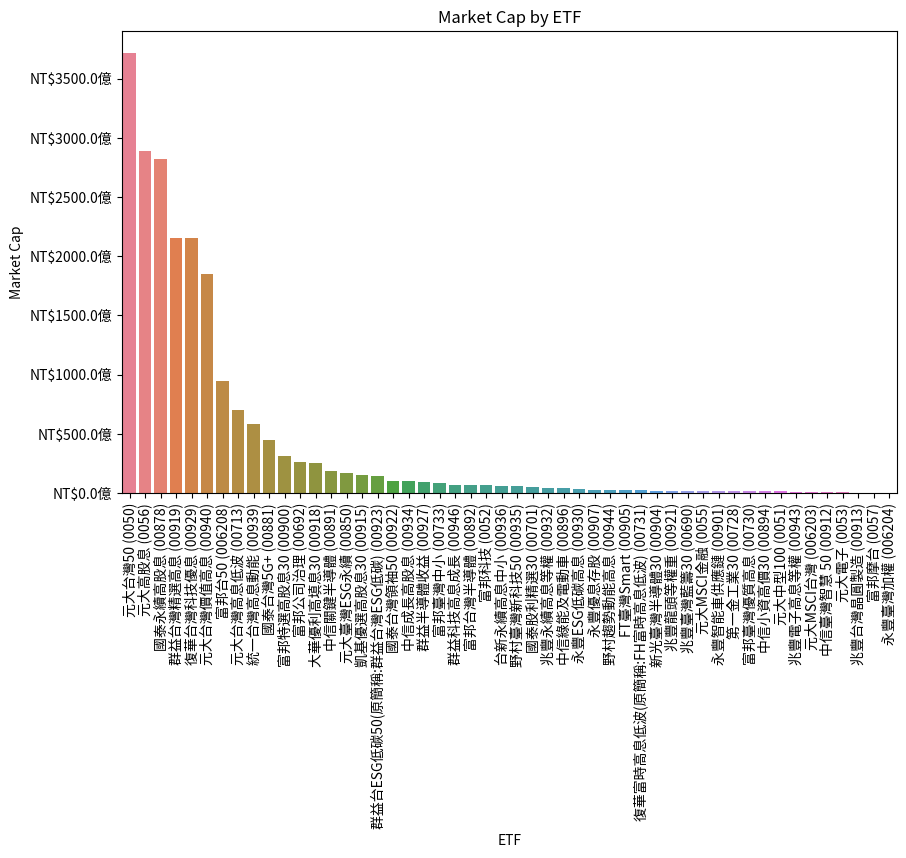

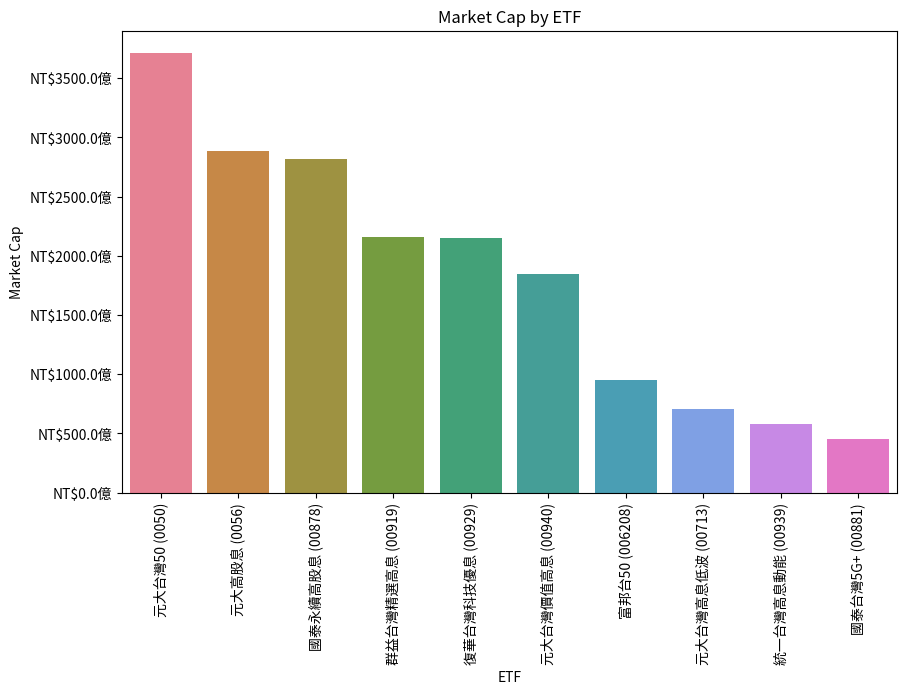

In [8]:
# 先簡單畫圖
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

def plot_bar(merged_df_subset):
    value_counts = merged_df_subset['code'].value_counts(dropna=False)
    sizes = value_counts.values
    colors = sns.color_palette("husl", len(sizes))

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='code', y='Market Cap', hue='code', data=merged_df_subset, palette='husl')

    def currency_formatter(x, pos):
        return f'NT${x/1e8:.1f}億'

    formatter = ticker.FuncFormatter(currency_formatter)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.title('Market Cap by ETF')
    plt.xlabel('ETF')
    plt.ylabel('Market Cap')
    # plt.xticks(merged_df_subset['code'], merged_df_subset['short_name'], rotation=90)
    labels = merged_df_subset['short_name'] + ' (' + merged_df_subset['code'] + ')'
    plt.xticks(ticks=range(len(merged_df_subset['code'])), labels=labels, rotation=90)

    # plt.tight_layout()
    plt.show()


merged_df_subset = df_merged_domestic[['code','short_name', 'Market Cap']].sort_values(by='Market Cap', ascending=False)

plot_bar(merged_df_subset)
plot_bar(merged_df_subset.head(10))

# ETF 持股狀況

In [ ]:
# https://www.moneydj.com/ETF/X/Basic/Basic0007B.xdjhtm?etfid=00915.TW
